In [5]:
import torch
import pandas as pd
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

RANDOM_SEED = 20

In [6]:
# Creating the dataset

n_samples=1000

X, y = make_moons(n_samples,
           noise=0.03,
           random_state=42)

In [7]:
# Dataframe just to view the data in a table

moons = pd.DataFrame({"X1": X[:, 0],
              "X2": X[:, 1],
              "label": y})

moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


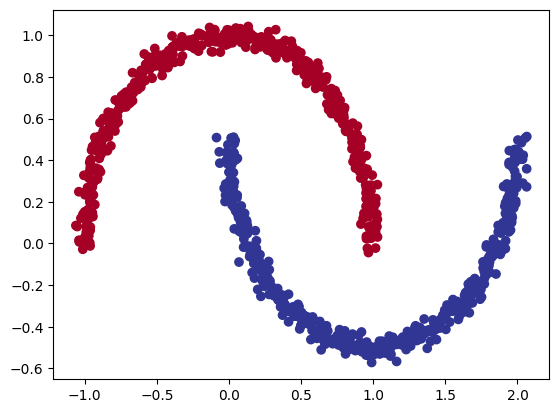

In [8]:
# Visualize!

import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

# WOW THAT LOOKS GOOD

In [9]:
# Turn data into float tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Setup the split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RANDOM_SEED)

In [10]:
import torch 
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=1)
            # Remember that one out feature is used for binary classification
        )


    def forward(self, x):
        return self.layers(x)
    
model_0 = MoonModelV0()

model_0

MoonModelV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [11]:
# Creating my loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                               lr=0.01)

In [23]:
y_logits = model_0(X_train).squeeze()
y_preds = torch.round(torch.sigmoid(y_logits))

test_logits = model_0(X_test).squeeze()
test_preds = torch.round(torch.sigmoid(test_logits))

y_preds.shape, test_preds.shape

(torch.Size([800]), torch.Size([200]))

In [30]:
torch.manual_seed(42)

epochs = 5000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

    ### Training
    model_0.train()
    import torchmetrics
    from torchmetrics.classification import BinaryAccuracy

    # 1. Forward Pass
    # We are receiving logits out of our model,
    # they need to be pred probs in our training/testing loop
    y_logits = model_0(X_train).squeeze() # To match the dimensions
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate the loss/accuracy

    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss
    metric = torchmetrics.Accuracy(task="binary", num_classes=2).to(device)
    acc = metric(y_preds, y_train) * 100

    # 3. Zero grad

    optimizer.zero_grad()

    # 4. Backpropagation

    loss.backward()

    # 5. Optimizer step

    optimizer.step()

    ### Testing

    model_0.eval()

    with torch.inference_mode():

    # 1. Forward Pass
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
    # 2. Test loss and acc
        test_loss = loss_fn(y_logits, y_train)
        test_acc = metric(y_preds, y_train) * 100

    # Print out what's happening

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.1554, Accuracy: 93.00% | Test loss: 0.1554, Test accuracy: 93.00%
Epoch: 100 | Loss: 0.1516, Accuracy: 93.00% | Test loss: 0.1516, Test accuracy: 93.00%
Epoch: 200 | Loss: 0.1477, Accuracy: 93.38% | Test loss: 0.1477, Test accuracy: 93.38%
Epoch: 300 | Loss: 0.1437, Accuracy: 93.38% | Test loss: 0.1437, Test accuracy: 93.38%
Epoch: 400 | Loss: 0.1397, Accuracy: 93.50% | Test loss: 0.1397, Test accuracy: 93.50%
Epoch: 500 | Loss: 0.1356, Accuracy: 93.75% | Test loss: 0.1356, Test accuracy: 93.75%
Epoch: 600 | Loss: 0.1315, Accuracy: 93.88% | Test loss: 0.1315, Test accuracy: 93.88%
Epoch: 700 | Loss: 0.1275, Accuracy: 94.12% | Test loss: 0.1275, Test accuracy: 94.12%
Epoch: 800 | Loss: 0.1234, Accuracy: 94.62% | Test loss: 0.1234, Test accuracy: 94.62%
Epoch: 900 | Loss: 0.1193, Accuracy: 95.00% | Test loss: 0.1193, Test accuracy: 95.00%
Epoch: 1000 | Loss: 0.1153, Accuracy: 95.50% | Test loss: 0.1153, Test accuracy: 95.50%
Epoch: 1100 | Loss: 0.1113, Accuracy: 95.88%

In [32]:
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# This function allows us to visualise the data

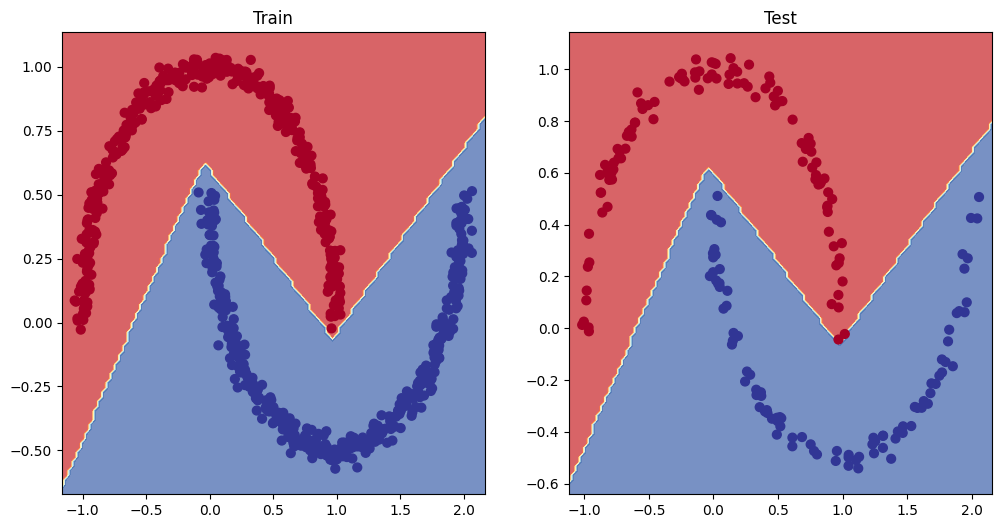

In [34]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)